# Time Series Forecasting Using Transformer Network
Training a transformer model to forecast time series sequence of Thermic Oil Heater Inlet Temperature  
Using 10 timesteps to forecast 1 forward timestep

# 1. Definition

### 1.1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import wandb

### 1.2. Load dataset and set global variables

In [2]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 64

# check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("your device is: ", device)

# read facebook dataset
df = pd.read_csv("../data/final_df_002.csv")
df.head()

your device is:  cuda


,Date Time,Heater Heat Output,T.F Heater Outlet Flow Transmitter,T.F. Heater Serpentine Coil Outlet Temperature,Heater Outlet Flue Gas O2 Analyzer,T.F. Heater Outlet Flue Gas Temperature,Average T.F. Heater Outlet Temperature,Average T.F. Heater Serpentine Coil Inlet Temperature,Average Furnace Exit Temperature
0,2024-08-01 06:40:00,5142770.5,489.726562,223.199997,6.488715,392.299988,236.03333,212.949997,716.25
1,2024-08-01 06:50:00,5142770.5,489.726562,223.199997,6.488715,392.299988,236.03333,212.949997,716.25
2,2024-08-01 07:00:00,5142770.5,489.726562,223.199997,6.488715,392.299988,236.03333,212.949997,716.25
3,2024-08-01 07:10:00,5142770.5,489.726562,223.199997,6.488715,392.299988,236.03333,212.949997,716.25
4,2024-08-01 07:20:00,5142770.5,489.726562,223.199997,6.488715,392.299988,236.03333,212.949997,716.25


In [23]:
df.columns

Index(['Date Time', 'Heater Heat Output', 'T.F Heater Outlet Flow Transmitter',
       'T.F. Heater Serpentine Coil Outlet Temperature',
       'Heater Outlet Flue Gas O2 Analyzer',
       'T.F. Heater Outlet Flue Gas Temperature',
       'Average T.F. Heater Outlet Temperature',
       'Average T.F. Heater Serpentine Coil Inlet Temperature',
       'Average Furnace Exit Temperature'],
      dtype='object')

### 1.3. Preprocessing

In [24]:
# logarithmic normalization
# open = df["Average T.F. Heater Serpentine Coil Inlet Temperature"]
# open = np.array(open)
# open_logreturn = np.diff(np.log(open))
# open_csum_logreturn = open_logreturn.cumsum()


close = df["Average T.F. Heater Serpentine Coil Inlet Temperature"]
close = np.array(close)
close_logreturn = np.diff(np.log(close))
close_csum_logreturn = close_logreturn.cumsum()


# average = df["Average T.F. Heater Outlet Temperature"].fillna(method="ffill")
# average = np.array(average)
# average_logreturn = np.diff(np.log(average))
# average_csum_logreturn = average_logreturn.cumsum()

### 1.4. Plot input dataframes

Text(0, 0.5, 'Close Price')

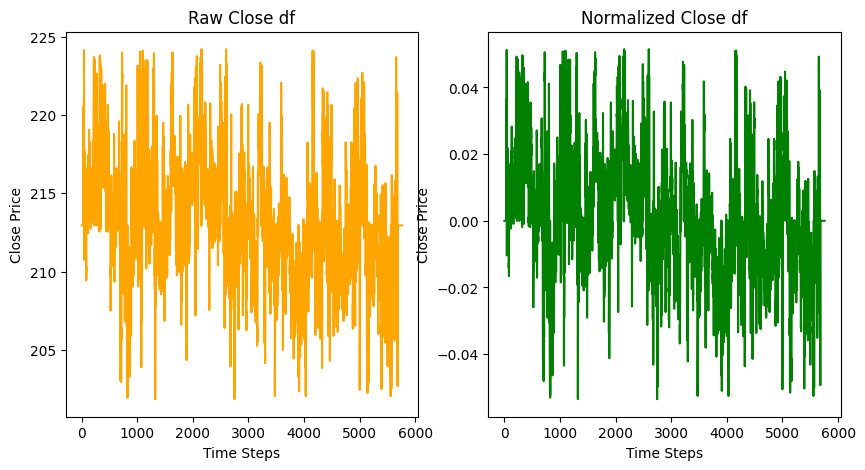

In [25]:
fig = plt.figure(figsize=(10, 5))

# plt.subplot(3, 2, 1)
# plt.plot(open, color="blue")
# plt.title("Raw Open df")
# plt.xlabel("Time Steps")
# plt.ylabel("Open Price")

# plt.subplot(3, 2, 2)
# plt.plot(open_csum_logreturn, color="red")
# plt.title("Normalized Open df")
# plt.xlabel("Time Steps")
# plt.ylabel("Open Price")

plt.subplot(1, 2, 1)
plt.plot(close, color="orange")
plt.title("Raw Close df")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")

plt.subplot(1, 2, 2)
plt.plot(close_csum_logreturn, color="green")
plt.title("Normalized Close df")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")

# plt.subplot(3, 2, 5)
# plt.plot(average, color="magenta")
# plt.title("Raw average df")
# plt.xlabel("Time Steps")
# plt.ylabel("average Price")

# plt.subplot(3, 2, 6)
# plt.plot(average_csum_logreturn, color="black")
# plt.title("Normalized average df")
# plt.xlabel("Time Steps")
# plt.ylabel("average Price")

Plot shows the reduced scale of the closing prices

# 2. Model Definition

### 2.1. Positional Encoding Layer

In [26]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

### 2.2. Transformer Model

In [27]:
class transformer(nn.Module):
    def __init__(self, feature_size=250, num_layers=2, dropout=0.0):
        super(transformer, self).__init__()
        self.model_type = "Transformer"

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if(self.src_mask is None or self.src_mask.size(0) != len(src)):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

# 3. Utils Functions




### 3.1. Create Window Sequence

In [28]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

### 3.2. Split Data
Split data into the train and testing set, prepared in windowed sequences and pass through GPU

In [29]:
def get_data(data, split):

    series = data

    split = round(split * len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()

    # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
    # Similar to image transformation to allow model to train on wider data sets
    train_data = 2 * train_data

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data, input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

### 3.3. Split into training batches

In [30]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

### 3.4. Training Function

In [31]:
def train(train_data):
    model.train()
    total_loss = 0.0
    start_time = time.time()
    
    # Initialize metrics accumulators
    mse_sum = 0.0
    mae_sum = 0.0
    batch_count = 0

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        # Calculate metrics
        with torch.no_grad():
            mse_batch = loss.item()
            rmse_batch = np.sqrt(mse_batch)
            mae_batch = torch.mean(torch.abs(output - targets)).item()
            
            mse_sum += mse_batch
            mae_sum += mae_batch
            batch_count += 1

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if(batch % log_interval == 0 and batch > 0):
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print("| epoch {:3d} | {:5d}/{:5d} batches | "
                  "lr {:02.10f} | {:5.2f} ms | "
                  "loss {:5.7f}".format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()
    
    # Calculate average metrics for the epoch
    avg_mse = mse_sum / batch_count
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = mae_sum / batch_count
    
    # Evaluate validation metrics
    val_mse, val_rmse, val_mae = evaluate(model, val_data)
    
    # Store metrics
    train_mse_history.append(avg_mse)
    train_rmse_history.append(avg_rmse)
    train_mae_history.append(avg_mae)
    val_mse_history.append(val_mse)
    val_rmse_history.append(val_rmse)
    val_mae_history.append(val_mae)
    
    # wandb.log({
    #     "MSE training loss": avg_mse,
    #     "RMSE training loss": avg_rmse,
    #     "MAE training loss": avg_mae,
    #     "MSE validation loss": val_mse,
    #     "RMSE validation loss": val_rmse,
    #     "MAE validation loss": val_mae
    # })
    
    return avg_mse, avg_rmse, avg_mae, val_mse, val_rmse, val_mae

### 3.5. Evaluation Function

In [46]:
def evaluate(eval_model, data_source):
    eval_model.eval()
    mse_sum = 0.0
    mae_sum = 0.0
    total_samples = 0
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            
            # Calculate MSE
            mse_batch = criterion(output, targets).cpu().item()
            batch_size = len(data[0])
            
            # Calculate MAE
            mae_batch = torch.mean(torch.abs(output - targets)).cpu().item()
            
            mse_sum += mse_batch * batch_size
            mae_sum += mae_batch * batch_size
            total_samples += batch_size
    
    # Calculate average metrics
    avg_mse = mse_sum / total_samples
    avg_rmse = np.sqrt(avg_mse)
    avg_mae = mae_sum / total_samples
    
    return avg_mse, avg_rmse, avg_mae

### 3.6. Forecast Function

#### 3.6.1. for one time step from window sequence

In [33]:
def model_forecast(model, seqence):
    model.eval()
    total_loss = 0.0
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode="constant", constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):
            output = model(seq[-output_window:])
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

#### 3.6.2. for entire sequence

In [34]:
def forecast_seq(model, sequences):

    start_timer = time.time()
    model.eval()
    forecast_seq = torch.Tensor(0)
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

# 4. Train Phase

### 4.1. Prepare data for train model

In [35]:
train_data, val_data = get_data(close_logreturn, 0.8) 
model = transformer().to(device)

/ml_data/env/ts/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


### 4.2. Set Model Parameters

In [69]:
# class RMSELoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.eps=1e-6

#     def forward(self,ground_truth,prediction):
#         loss=torch.mean(torch.sqrt(torch.sum(torch.square(ground_truth-prediction),axis=-1))) + self.eps
#         return loss

criterion = nn.MSELoss()
lr = 0.0005
epochs = 2

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

In [37]:
# Initialize metric history lists to track training and validation metrics
train_mse_history = []
train_rmse_history = []
train_mae_history = []
val_mse_history = []
val_rmse_history = []
val_mae_history = []


### 4.3. Training Loop

In [70]:
config = {"lr": lr, "epochs": epochs, "batch_size": batch_size}

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if(epoch % epochs == 0): # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print("-" * 80)
        print("| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}".format(epoch, (time.time() - epoch_start_time), val_loss[0]))
        print("-" * 80)

    else:
        print("-" * 80)
        print("| end of epoch {:3d} | time: {:5.2f}s".format(epoch, (time.time() - epoch_start_time)))
        print("-" * 80)

    scheduler.step()
# run.finish()


/ml_data/env/ts/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


| epoch   1 |    14/   71 batches | lr 0.0005000000 |  8.63 ms | loss 0.0119151
| epoch   1 |    28/   71 batches | lr 0.0005000000 |  7.62 ms | loss 0.0015131
| epoch   1 |    42/   71 batches | lr 0.0005000000 |  7.79 ms | loss 0.0029246
| epoch   1 |    56/   71 batches | lr 0.0005000000 |  7.73 ms | loss 0.0013981


| epoch   1 |    70/   71 batches | lr 0.0005000000 |  7.93 ms | loss 0.0006703
--------------------------------------------------------------------------------
| end of epoch   1 | time:  0.58s
--------------------------------------------------------------------------------
| epoch   2 |    14/   71 batches | lr 0.0004512500 |  8.21 ms | loss 0.0005168
| epoch   2 |    28/   71 batches | lr 0.0004512500 |  7.80 ms | loss 0.0004835
| epoch   2 |    42/   71 batches | lr 0.0004512500 |  7.67 ms | loss 0.0003607
| epoch   2 |    56/   71 batches | lr 0.0004512500 |  7.93 ms | loss 0.0005582
| epoch   2 |    70/   71 batches | lr 0.0004512500 |  7.72 ms | loss 0.0003637
--------------------------------------------------------------------------------
| end of epoch   2 | time:  0.60s | valid loss: 0.0002033
--------------------------------------------------------------------------------


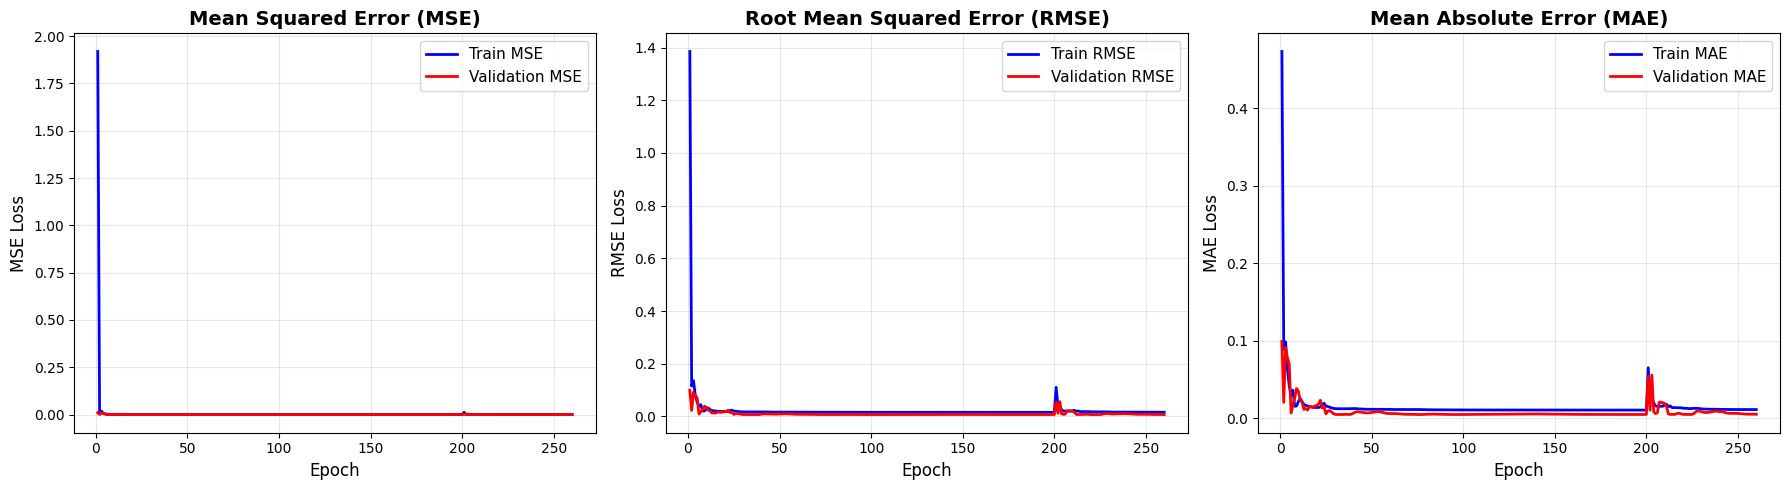


FINAL METRICS SUMMARY
Training   - MSE: 0.0002575, RMSE: 0.0160455, MAE: 0.0109604
Validation - MSE: 0.0000535, RMSE: 0.0073110, MAE: 0.0048560


In [48]:
# Plot training and validation loss metrics
if len(train_mse_history) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs_range = range(1, len(train_mse_history) + 1)
    
    # Plot MSE
    axes[0].plot(epochs_range, train_mse_history, label='Train MSE', color='blue', linewidth=2)
    axes[0].plot(epochs_range, val_mse_history, label='Validation MSE', color='red', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('MSE Loss', fontsize=12)
    axes[0].set_title('Mean Squared Error (MSE)', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot RMSE
    axes[1].plot(epochs_range, train_rmse_history, label='Train RMSE', color='blue', linewidth=2)
    axes[1].plot(epochs_range, val_rmse_history, label='Validation RMSE', color='red', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('RMSE Loss', fontsize=12)
    axes[1].set_title('Root Mean Squared Error (RMSE)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Plot MAE
    axes[2].plot(epochs_range, train_mae_history, label='Train MAE', color='blue', linewidth=2)
    axes[2].plot(epochs_range, val_mae_history, label='Validation MAE', color='red', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('MAE Loss', fontsize=12)
    axes[2].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
    axes[2].legend(fontsize=11)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("\n" + "="*80)
    print("FINAL METRICS SUMMARY")
    print("="*80)
    print(f"Training   - MSE: {train_mse_history[-1]:.7f}, RMSE: {train_rmse_history[-1]:.7f}, MAE: {train_mae_history[-1]:.7f}")
    print(f"Validation - MSE: {val_mse_history[-1]:.7f}, RMSE: {val_rmse_history[-1]:.7f}, MAE: {val_mae_history[-1]:.7f}")
    print("="*80)
else:
    print("No training metrics available. Please run the training loop first.")


In [49]:
test_result, truth = forecast_seq(model, val_data)

2.9272303581237793 sec


# 5. Results

### 5.1. Plot forecasted sequence vs actual

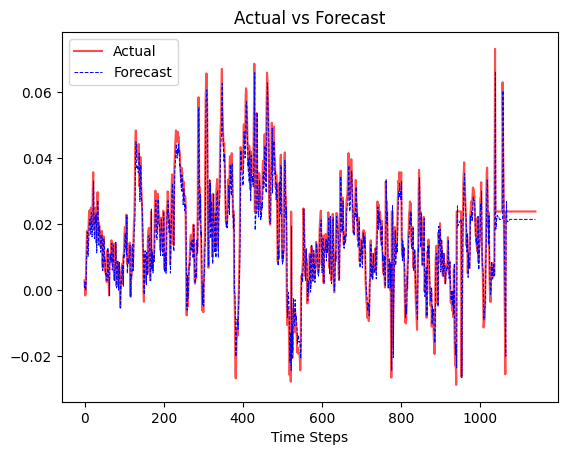

In [50]:
plt.plot(truth, color="red", alpha=0.7)
plt.plot(test_result, color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()

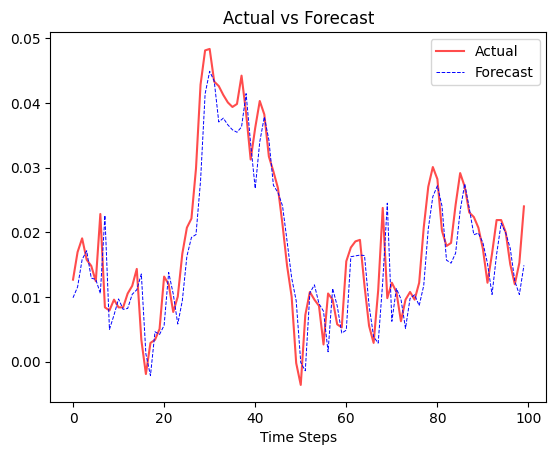

In [51]:
###Superimpose the forecasted sequence on the actual sequence
plt.plot(truth[100:200], color="red", alpha=0.7)
plt.plot(test_result[100:200], color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()

# 6. Save Model

In [52]:
torch.save(model.state_dict(), "../model/transformer_model.pth")

# 7. Validation Phase

### 7.1. Load Model

In [53]:
model_val = transformer()
model_val.load_state_dict(torch.load("../model/transformer_model.pth"))
model_val.to(device)

/tmp/ipykernel_3100057/3027964807.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_val.load_state_dict(torch.load("../model/transformer_model.pth"))


transformer(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=2048, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (linear2): Linear(in_features=2048, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.0, inplace=False)
    (dropout2): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
        )
        (linear1): Linear(in_features=250, out_features=2048, bias=True)
        (dropout

Testing model on Boeing stock from the same time period

### 7.2. Average T.F. Heater Outlet Temperature

In [54]:
# df2 = pd.read_csv("../data/boeing.csv")
close2 = df["Average T.F. Heater Outlet Temperature"]
close2 = np.array(close2)
logreturn2 = np.diff(np.log(close2))

# average = df["Average T.F. Heater Outlet Temperature"].fillna(method="ffill")
# average = np.array(average)
# average_logreturn = np.diff(np.log(average))

In [56]:
train_data2, val_data2 = get_data(logreturn2, 0.8)
test2_eval = evaluate(model_val, val_data2)
print(f"boeing test loss: {test2_eval}")

boeing test loss: (6.89549787989164e-05, np.float64(0.008303913462874984), 0.0059724447333760425)


2.9403436183929443 sec


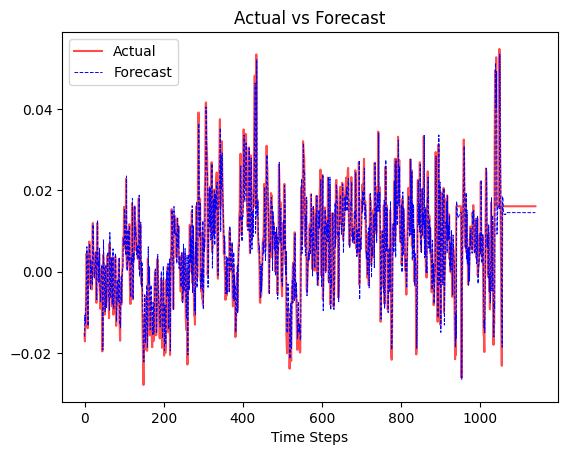

In [57]:
test_result2, truth2 = forecast_seq(model_val, val_data2)

plt.plot(truth2, color="red", alpha=0.7)
plt.plot(test_result2, color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()

### 7.3. T.F. Heater Serpentine Coil Outlet Temperature

In [58]:
# df3 = pd.read_csv("../data/jp_morgan.csv")
close3 = df["T.F. Heater Serpentine Coil Outlet Temperature"]
close3 = np.array(close3)
logreturn3 = np.diff(np.log(close3))

In [68]:
train_data3, val_data3 = get_data(logreturn3, 0.6)
test3_eval = evaluate(model_val, val_data3)
print(f"T.F. Heater Serpentine Coil Outlet Temperature test loss:{test3_eval[1]:,.5f}")

T.F. Heater Serpentine Coil Outlet Temperature test loss:0.00808


In [ ]:
test_result3, truth3 = forecast_seq(model_val, val_data3)

plt.plot(truth3, color="red", alpha=0.7)
plt.plot(test_result3, color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()

In [ ]:
test_result3, truth3 = forecast_seq(model_val, val_data3)

plt.plot(truth3[100:200], color="red", alpha=0.7)
plt.plot(test_result3[100:200], color="blue", linestyle="dashed", linewidth=0.7)
plt.title("Actual vs Forecast")
plt.legend(["Actual", "Forecast"])
plt.xlabel("Time Steps")
plt.show()